## Introduction to model stacking using sklearn models

#### This workshop uses House Price Data from Kaggle to demonstrate some frequently used machine learning techniques and a model stacking and blending appraoch

#### Machine Learning Models Covered:
**Sklearn:**   
Extra Trees   
Random Forest   
Lasso Regression   
Ridge Kernel Regression
    
**XGBoost:**   
XGBoost (Extreme Gradient Boosting)   



### Initialization: import required packages   
Import the data sctructure and analysis packages

In [1]:
import pandas as pd
import numpy as np

/Users/meichengshih/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


Import machine learning models

In [2]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

Import packages related to model ensembling and the other packages

In [3]:
import time
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold

Read cleaned data, the data cleaning process will not be discussed in this workshop

In [4]:
train=pd.read_csv('./train-b.csv',index_col=0)
to_pred=pd.read_csv('./test-b.csv',index_col=0)
## Read the Log of House Price
target=np.log(pd.read_csv('./target.csv',index_col=0, header=None).astype('float32'))

Define first layer regressors and their corresponding parameters, the parameters were obtained from Bayesian Optimization based parameter tunning process. We will not discuss the details of parameter tuning today. 

This example will contain 5 first-layer regressors

In [5]:
# Define Kernel Rdige Model
kr=KernelRidge(alpha=10**(-1.75),gamma=10**(-2.25),kernel='rbf')

# Define Lasso Model
lasso=Lasso(alpha=10**(-3.65),max_iter=3000)

# Define XGBoost Model
xgbr=xgb.XGBRegressor(colsample_bytree=0.7,gamma=0.02,learning_rate=0.09,max_depth=4, min_child_weight=1,
                      n_estimators=420,reg_alpha=0.1,reg_lambda=0.3,subsample=0.75)

# Define Extra Trees Regressor
extr=ExtraTreesRegressor(max_depth=28,max_features=0.9,n_estimators=450)

# Define Random Forest Regressor
rfr=RandomForestRegressor(max_depth=25,max_features=0.35,n_estimators=400,min_samples_leaf=1)

# Define a list of regressors
frgrs=[kr,lasso,xgbr,extr,rfr] # Kernel Ridge, Lasso, XGBoost, Extra Tress and Random Forest Regressors

Generate performance recorded matrix, and the train and test matrix for the second layer regressor

In [6]:
# Define number of folds used for model stacking
nf=10

# Record the performance of each fold iteration
eval_rec=np.zeros((nf,len(frgrs)))

# Record the train and test matrix for second layer regressor at the end of each fold iteration
blend_train_temp=np.zeros((train.shape[0]))
blend_pred_temp=np.zeros((to_pred.shape[0]))

# Record the final train and test matrix for the second layer regressor
blend_train=np.zeros((train.shape[0],len(frgrs)))
blend_pred=np.zeros((to_pred.shape[0],len(frgrs)))

Start model stacking process

In [7]:
## Record strat time
stime=time.time()
## K-Fold with Shufffle
skf = list(KFold(len(target), nf ,shuffle=True))
## Loop over all regressors
for j, rgr in enumerate(frgrs):
    print (str(j+1)+"th Regressor")
    print ("(Fold,RMSE,Time)")
    ## Loop over all folds
    for i in xrange(nf):
        ### For each fold iteration, determine the train and test data based on the generated fold indices
        trainind, testind=skf[i]
        xtrain, xtest = train.ix[trainind,:], train.ix[testind,:]
        ytrain, ytest = target.ix[trainind], target.ix[testind]
        ### Converting y into 1d array 
        ytrain=ytrain.ix[:,1]
        ### Train a model with the train data x and y
        rgr.fit(xtrain, ytrain)
        ### Predict the y of the test data
        ytest_pred = rgr.predict(xtest).astype('float32')
        ### Record the predicted y of test data
        blend_train_temp[testind]=ytest_pred
        ### Predict the y of the data that needed to be predicted
        pred = rgr.predict(to_pred).astype('float32')
        
        ### Record the y of the data that needed to be predicted    
        if i==0:
            blend_pred_temp=pred
        else:
            blend_pred_temp=blend_pred_temp+pred
        
        ### Show the performance of a model at each fold iteration and the total time spent
        print (i+1, mean_squared_error(ytest,ytest_pred)**0.5, (time.time()-stime))
        ### Record the performance of a model at each fold iteration
        eval_rec[i,j]=mean_squared_error(ytest,ytest_pred)**0.5
    
    ### Record the generated train and predict data from each regressor for the second layer regressor
    blend_train[:,j]=blend_train_temp
    blend_pred[:,j]=blend_pred_temp/float(nf)

1th Regressor
(Fold,RMSE,Time)
(1, 0.11291202438041688, 0.1387338638305664)
(2, 0.15106856514943601, 0.2523078918457031)
(3, 0.11669449417574082, 0.3674309253692627)
(4, 0.11590257572979983, 0.47429990768432617)
(5, 0.11215568277253304, 0.5805749893188477)
(6, 0.11936665809154924, 0.6816380023956299)
(7, 0.15002056517292528, 0.7912240028381348)
(8, 0.14914553328960511, 0.8880949020385742)
(9, 0.10074072566456485, 0.9982109069824219)
(10, 0.1316759905300397, 1.0983200073242188)
2th Regressor
(Fold,RMSE,Time)
(1, 0.10916659817514504, 1.1314029693603516)
(2, 0.15709929913383294, 1.1822500228881836)
(3, 0.12137437421615778, 1.2103688716888428)
(4, 0.10481506446994894, 1.2379229068756104)
(5, 0.10831519530597314, 1.267827033996582)
(6, 0.11150363004659929, 1.2963628768920898)
(7, 0.16613745426606147, 1.3311879634857178)
(8, 0.13230362341255511, 1.3875489234924316)
(9, 0.094869849386240407, 1.4212539196014404)
(10, 0.1217130506586592, 1.458651065826416)
3th Regressor
(Fold,RMSE,Time)
(1, 0.1

Check the average performance of each model under all fold iterations

In [8]:
eval_rec.mean(axis=0)
# 0:Kernel Ridge, 1:Lasso, 2:XGBoost, 3:Extra Tress 4:Random Forest Regressors

array([ 0.12596828,  0.12272981,  0.12222289,  0.13985954,  0.13572247])

Set the second layer model

In [9]:
second_rgr=KernelRidge(alpha=10**(-1.35),
            gamma=10**(-1.40),
            kernel='rbf')

Calculate the performance of second layer regressor, the blending regressor

In [10]:
### Generate the performance recording matrix
sec_eval_rec=np.zeros((nf))

for i in xrange(nf):
    ### For each fold iteration, determine the train and test data based on the generated fold indices
    trainind, testind=skf[i]
    xtrain, xtest = blend_train[trainind,:], blend_train[testind,:]
    ytrain, ytest = target.ix[trainind], target.ix[testind]
    ### Converting y into 1d array 
    ytrain=ytrain.ix[:,1]
    ### Train a model with the train data x and y
    second_rgr.fit(xtrain, ytrain)
    ### Predict the y of the test data
    ytest_pred = second_rgr.predict(xtest).astype('float32')
    ### Show the performance of a model at each fold iteration and the total time spent
    print (i+1, mean_squared_error(ytest,ytest_pred)**0.5, (time.time()-stime))
    ### Record the performance of a model at each fold iteration
    sec_eval_rec[i]=mean_squared_error(ytest,ytest_pred)**0.5

(1, 0.10949587528933272, 216.913006067276)
(2, 0.14426540721462475, 216.97926998138428)
(3, 0.11282344918202704, 217.04734897613525)
(4, 0.10668201988042315, 217.10916900634766)
(5, 0.11126965945107385, 217.1749939918518)
(6, 0.11193920455579412, 217.23257899284363)
(7, 0.11255934494432465, 217.29558300971985)
(8, 0.12891404532935316, 217.35723400115967)
(9, 0.099384306031069944, 217.4225468635559)
(10, 0.12558551094136983, 217.48767685890198)


Check the performance of second layer classifier

In [11]:
sec_eval_rec.mean(axis=0)

0.11629188228193929

#### Compare the performances with a bar chart

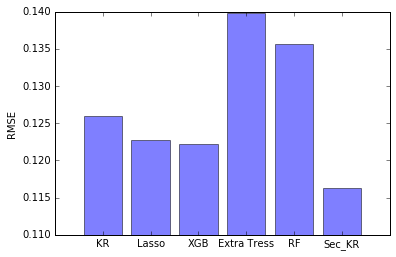

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
perf=np.append(eval_rec.mean(axis=0),(sec_eval_rec.mean(axis=0)))
index = np.arange(len(perf))
objects = ('KR', 'Lasso', 'XGB', 'Extra Tress', 'RF', 'Sec_KR')
plt.bar(index, perf, align='center', alpha=0.5)
plt.xticks(index, objects)
plt.ylabel('RMSE')
axes = plt.gca()
axes.set_ylim([0.11, 0.14])
plt.show()

Using Lasso as the second layer classifier

In [12]:
second_rgr2=Lasso(alpha=10**(-3.35),max_iter=3000)

### Generate the performance recording matrix
lasso_sec_eval_rec=np.zeros((nf))

for i in xrange(nf):
    ### For each fold iteration, determine the train and test data based on the generated fold indices
    trainind, testind=skf[i]
    xtrain, xtest = blend_train[trainind,:], blend_train[testind,:]
    ytrain, ytest = target.ix[trainind], target.ix[testind]
    ### Converting y into 1d array 
    ytrain=ytrain.ix[:,1]
    ### Train a model with the train data x and y
    second_rgr2.fit(xtrain, ytrain)
    ### Predict the y of the test data
    ytest_pred = second_rgr2.predict(xtest).astype('float32')
    ### Show the performance of a model at each fold iteration and the total time spent
    print (i+1, mean_squared_error(ytest,ytest_pred)**0.5, (time.time()-stime))
    ### Record the performance of a model at each fold iteration
    lasso_sec_eval_rec[i]=mean_squared_error(ytest,ytest_pred)**0.5

(1, 0.10716281343841634, 223.10286593437195)
(2, 0.15245123885883094, 223.1054220199585)
(3, 0.10269828876957779, 223.10758590698242)
(4, 0.106407040531454, 223.10973000526428)
(5, 0.10733733318339661, 223.11270189285278)
(6, 0.11069720917390052, 223.11608505249023)
(7, 0.13790112528386791, 223.11850500106812)
(8, 0.13297518415382717, 223.12064790725708)
(9, 0.090050992154706064, 223.12479090690613)
(10, 0.12641792457998713, 223.12762594223022)


In [13]:
lasso_sec_eval_rec.mean(axis=0)

0.11740991501279648

Using XGBoost as the second layer classifier

In [14]:
second_rgr3=xgb.XGBRegressor(colsample_bytree=0.35,gamma=0.085,learning_rate=0.12,max_depth=5, min_child_weight=5.75,
                      n_estimators=520,reg_alpha=0.6,reg_lambda=4.75,subsample=0.25)

### Generate the performance recording matrix
xgb_sec_eval_rec=np.zeros((nf))

for i in xrange(nf):
    ### For each fold iteration, determine the train and test data based on the generated fold indices
    trainind, testind=skf[i]
    xtrain, xtest = blend_train[trainind,:], blend_train[testind,:]
    ytrain, ytest = target.ix[trainind], target.ix[testind]
    ### Converting y into 1d array 
    ytrain=ytrain.ix[:,1]
    ### Train a model with the train data x and y
    second_rgr3.fit(xtrain, ytrain)
    ### Predict the y of the test data
    ytest_pred = second_rgr3.predict(xtest).astype('float32')
    ### Show the performance of a model at each fold iteration and the total time spent
    print (i+1, mean_squared_error(ytest,ytest_pred)**0.5, (time.time()-stime))
    ### Record the performance of a model at each fold iteration
    xgb_sec_eval_rec[i]=mean_squared_error(ytest,ytest_pred)**0.5

(1, 0.11286751649214116, 230.6129229068756)
(2, 0.15081574065287254, 230.70890307426453)
(3, 0.10702238359412038, 230.80807495117188)
(4, 0.1058286645197693, 230.9005959033966)
(5, 0.11319395927906727, 230.9901568889618)
(6, 0.11939704379422914, 231.08454203605652)
(7, 0.12898723630313516, 231.1784119606018)
(8, 0.1363778769533176, 231.26709008216858)
(9, 0.099487838275625254, 231.3576898574829)
(10, 0.13041034921857797, 231.4561529159546)


In [15]:
xgb_sec_eval_rec.mean(axis=0)

0.12043886090828557

#### Comparison between the difference models as the second layer regressor, the red line is the best performance of first layer models

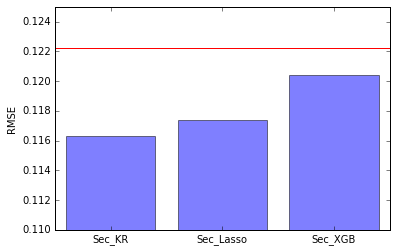

In [19]:
perf=np.append((sec_eval_rec.mean(axis=0)),(lasso_sec_eval_rec.mean(axis=0)))
perf=np.append(perf,(xgb_sec_eval_rec.mean(axis=0)))
index = np.arange(len(perf))
objects = ('Sec_KR', 'Sec_Lasso', 'Sec_XGB')
plt.bar(index, perf, align='center', alpha=0.5)
plt.xticks(index, objects)
plt.ylabel('RMSE')
axes = plt.gca()
axes.set_ylim([0.11, 0.125])
plt.axhline(y=0.12222289, color='red')
plt.show()

#### The reason why KR performs better than Lasso and XGB as the second layer regressor is because KR can deal with the homogeneious inputs better.  Based on this idea, the use of Neural Network as the second layer  is expected to generate a good quality of output too.